# Package installation

In [ ]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.1 MB/s eta 0:00:00


In [ ]:
import random
import gzip
import torch
import os
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from Bio import SeqIO
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


from sklearn.model_selection import train_test_split
from google.colab import drive
from torch.nn.utils.rnn import pad_sequence
drive.mount('/content/gdrive')

rootPath = "/content/gdrive/MyDrive/Colab_Notebooks_Xinyu/Bio"


Mounted at /content/gdrive


# Dataset processing

In [ ]:
from sklearn.model_selection import train_test_split
from collections import Counter

# Balancing the total number of each label
def load_fasta_gz(file_path, label):
    with gzip.open(file_path, "rt") as handle:
        return [(str(record.seq), label) for record in SeqIO.parse(handle, "fasta")]

def load_and_balance(file_path, label, max_samples):
    data = load_fasta_gz(file_path, label)
    random.shuffle(data)
    return data[:max_samples]

paths_labels = [
    (rootPath+"/DNAbindingprotein.fasta.gz", 0),
    (rootPath+"/Structuralprotein.fasta.gz", 1),
    (rootPath+"/Receptor.fasta.gz", 2),
    (rootPath+"/Transporter.fasta.gz", 3),
    (rootPath+"/Enzyme.fasta.gz", 4),
]

all_raw = [(load_fasta_gz(p, l), l) for p, l in paths_labels]
min_len = min(len(group[0]) for group in all_raw)

balanced_data = []
for file_path, label in paths_labels:
    balanced_data += load_and_balance(file_path, label, min_len)



# Step 2: shuffle
random.shuffle(balanced_data)
sequences, labels = zip(*balanced_data)

# train : validation : test = 8:1:1
X_temp, X_test, y_temp, y_test = train_test_split(
    sequences, labels, test_size=0.1, random_state=42, stratify=labels
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.1111, random_state=42, stratify=y_temp
)

# Check
print("Each class sample count after balancing:", min_len)
print("Train:", Counter(y_train))
print("Valid:", Counter(y_valid))
print("Test: ", Counter(y_test))


Each class sample count after balancing: 500
Train: Counter({3: 400, 1: 400, 2: 400, 0: 400, 4: 400})
Valid: Counter({2: 50, 3: 50, 4: 50, 1: 50, 0: 50})
Test:  Counter({4: 50, 2: 50, 3: 50, 0: 50, 1: 50})


In [ ]:
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
aa_to_idx = {aa: i+1 for i, aa in enumerate(amino_acids)}  # 0 for padding

def encode_sequence(seq):
    return torch.tensor([aa_to_idx.get(aa, 0) for aa in seq], dtype=torch.long)

def prepare_dataset(X, y):
    X_enc = [encode_sequence(seq) for seq in X]
    X_pad = pad_sequence(X_enc, batch_first=True)  # shape: (batch, max_len)
    y_tensor = torch.tensor(y, dtype=torch.long)
    return X_pad, y_tensor


In [ ]:


X_train_pad, y_train_tensor = prepare_dataset(X_train, y_train)
X_valid_pad, y_valid_tensor = prepare_dataset(X_valid, y_valid)

train_loader = DataLoader(TensorDataset(X_train_pad, y_train_tensor), batch_size=32, shuffle=True)
valid_loader = DataLoader(TensorDataset(X_valid_pad, y_valid_tensor), batch_size=32)


# RNN Model

In [ ]:
import torch
import torch.nn as nn
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class ProteinRNN(nn.Module):
    def __init__(self, num_classes=5, embedding_dim=32, hidden_dim=64, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=21, embedding_dim=embedding_dim, padding_idx=0)

        self.rnn = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )

        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim * 2, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.rnn(x)
        h_final = torch.mean(output, dim=1)
        x = self.dropout(h_final)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)




model = ProteinRNN()
print(f"Total trainable parameters: {count_parameters(model):,}")

Total trainable parameters: 55,141


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


In [ ]:
import torch


if torch.cuda.is_available():
    print("CUDA is available.")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("CUDA is not available. Running on CPU.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



❌ CUDA is not available. Running on CPU.
Using device: cpu


In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()


In [ ]:


X_train_pad, y_train_tensor = prepare_dataset(X_train, y_train)
X_valid_pad, y_valid_tensor = prepare_dataset(X_valid, y_valid)

train_loader = DataLoader(TensorDataset(X_train_pad, y_train_tensor), batch_size=32, shuffle=True)
valid_loader = DataLoader(TensorDataset(X_valid_pad, y_valid_tensor), batch_size=32)

model = ProteinRNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)



def evaluate(model, dataloader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            preds = model(X_batch).argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    return correct / total

train_accuracies = []
valid_accuracies = []

best_val_acc = 0.0
patience = 5
wait = 0
save_path = os.path.join(rootPath, "rnn_best_model.pt")

for epoch in range(50):
    # ---------- Training ----------
    model.train()
    correct = total = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        # Accuracy
        preds = outputs.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
    train_acc = correct / total
    train_accuracies.append(train_acc)

    # ---------- Validation ----------
    val_acc = evaluate(model, valid_loader)
    valid_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} | Train Acc: {train_acc:.4f} | Valid Acc: {val_acc:.4f}")

    # ---------- Early Stopping ----------
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path)
        wait = 0
        print(" Model improved and saved.")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break



Epoch 1 | Train Acc: 0.2115 | Valid Acc: 0.2120
 Model improved and saved.
Epoch 2 | Train Acc: 0.2770 | Valid Acc: 0.2760
 Model improved and saved.
Epoch 3 | Train Acc: 0.3435 | Valid Acc: 0.3400
 Model improved and saved.
Epoch 4 | Train Acc: 0.3140 | Valid Acc: 0.3240
Epoch 5 | Train Acc: 0.3450 | Valid Acc: 0.3440
 Model improved and saved.
Epoch 6 | Train Acc: 0.3390 | Valid Acc: 0.2880
Epoch 7 | Train Acc: 0.3765 | Valid Acc: 0.3720
 Model improved and saved.
Epoch 8 | Train Acc: 0.3890 | Valid Acc: 0.3520
Epoch 9 | Train Acc: 0.3990 | Valid Acc: 0.3640
Epoch 10 | Train Acc: 0.3820 | Valid Acc: 0.4480
 Model improved and saved.
Epoch 11 | Train Acc: 0.4230 | Valid Acc: 0.3840
Epoch 12 | Train Acc: 0.4150 | Valid Acc: 0.4320
Epoch 13 | Train Acc: 0.4245 | Valid Acc: 0.4320
Epoch 14 | Train Acc: 0.4335 | Valid Acc: 0.4360
Epoch 15 | Train Acc: 0.4505 | Valid Acc: 0.4800
 Model improved and saved.
Epoch 16 | Train Acc: 0.4500 | Valid Acc: 0.4360
Epoch 17 | Train Acc: 0.4705 | Valid

In [ ]:
def plot_tsne_projection(X_feat, y_labels, class_names, save_dir, prefix="model"):
    """
    t-SNE visualization。

    parameters：
        X_feat (np.ndarray)        : feature vector (N, D)
        y_labels (list[int])       : labels
        class_names (list[str])    : class name（Shown on figure）
        save_dir (str)             : Saving path
        prefix (str)               : prefix to distinguish，such as 'knn'、'svm'
    """
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os

    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"{prefix}_tsne_plot.png")

    # runing t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=2000)
    X_embedded = tsne.fit_transform(X_feat)

    # plot
    plt.figure(figsize=(8, 6))
    palette = sns.color_palette("Set2", len(set(y_labels)))

    sns.scatterplot(
        x=X_embedded[:, 0],
        y=X_embedded[:, 1],
        hue=y_labels,
        palette=palette,
        edgecolor='black',
        s=40,
        alpha=0.8,
        legend="full"
    )

    handles, _ = plt.gca().get_legend_handles_labels()
    plt.legend(handles, class_names, title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.title(f"t-SNE Projection of Protein Sequences ({prefix.upper()} Feature Space)")
    plt.xlabel("TSNE-1")
    plt.ylabel("TSNE-2")
    plt.tight_layout()
    plt.grid(True)

    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f" t-SNE has saved: {save_path}")


In [ ]:
def extract_rnn_features(model, dataloader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            output, _ = model.rnn(model.embedding(X_batch))   # shape: (batch, seq_len, hidden*2)
            h_final = torch.mean(output, dim=1)                # 平均池化
            features.append(h_final.cpu().numpy())
            labels.extend(y_batch.cpu().numpy())
    return np.vstack(features), np.array(labels)


In [ ]:
import numpy as np
X_rnn_feat, y_rnn = extract_rnn_features(model, train_loader)

plot_tsne_projection(
    X_feat=X_rnn_feat,
    y_labels=y_rnn,
    class_names=["DNABinding", "Structural", "Receptor", "Transporter", "Enzyme"],
    save_dir=os.path.join(rootPath, "rnn_results"),
    prefix="rnn"
)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


 t-SNE has saved: /content/gdrive/MyDrive/Colab_Notebooks_Xinyu/Bio/rnn_results/rnn_tsne_plot.png


In [ ]:
def save_training_results(
    root_path,
    train_accuracies,
    valid_accuracies,
    model,
    tokenizer=None,
    valid_loader=None,
    class_names=None,
    prefix=""
):
    import os
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
    import torch

    os.makedirs(root_path, exist_ok=True)

    # Step 1: Unify length
    min_len = min(len(train_accuracies), len(valid_accuracies))
    train_accuracies = train_accuracies[:min_len]
    valid_accuracies = valid_accuracies[:min_len]

    # Step 2: save CSV
    df = pd.DataFrame({
        "Epoch": list(range(1, min_len + 1)),
        "Train_Accuracy": train_accuracies,
        "Valid_Accuracy": valid_accuracies
    })
    df.to_csv(os.path.join(root_path, f"{prefix}accuracy_log.csv"), index=False)

    # Step 3: plot
    plt.figure()
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(root_path, f"{prefix}accuracy_plot.png"))
    plt.close()

    # Step 4: confusion metric
    if valid_loader and class_names:
        model.eval()
        all_preds, all_labels = [], []
        device = next(model.parameters()).device
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                preds = outputs.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())

        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(cmap='Blues', xticks_rotation=45)
        plt.title("Confusion Matrix")
        plt.savefig(os.path.join(root_path, f"{prefix}confusion_matrix.png"))
        plt.close()

        # Classification report
        with open(os.path.join(root_path, f"{prefix}classification_report.txt"), "w") as f:
            f.write(classification_report(all_labels, all_preds, target_names=class_names))

In [ ]:
save_training_results(
    root_path=os.path.join(rootPath, "rnn_results"),
    train_accuracies=train_accuracies,
    valid_accuracies=valid_accuracies,
    model=model,
    valid_loader=valid_loader,
    class_names=["DNABinding", "Structural", "Receptor", "Transporter", "Enzyme"],
    prefix="rnn_"
)



## Save results

# ESM2

In [ ]:
!pip install transformers datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which i

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "facebook/esm2_t6_8M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_dict({"sequence": X_train, "label": y_train})
valid_dataset = Dataset.from_dict({"sequence": X_valid, "label": y_valid})
test_dataset  = Dataset.from_dict({"sequence": X_test, "label": y_test})

# DatasetDict
dataset_dict = DatasetDict({
    "train": train_dataset,
    "validation": valid_dataset,
    "test": test_dataset
})

print(dataset_dict)

# check
print(dataset_dict["train"][0])


In [ ]:
from datasets import Dataset
import random

def preprocess_function(examples):
    return tokenizer(
        examples["sequence"],
        padding="max_length",
        truncation=True,
        max_length=128,
    )

encoded_dataset = dataset_dict.map(preprocess_function, batched=True)


In [ ]:
!pip install transformers==4.51.3



In [ ]:
import transformers
print(transformers.__version__)


4.51.3


In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

In [ ]:
from transformers import (
    TrainerCallback,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
import os

os.environ["WANDB_DISABLED"] = "true"

class MetricsLoggerCallback(TrainerCallback):
    def __init__(self):
        self.train_accuracies = []
        self.valid_accuracies = []

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics and "eval_accuracy" in metrics:
            self.valid_accuracies.append(metrics["eval_accuracy"])

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and "train_accuracy" in logs:
            self.train_accuracies.append(logs["train_accuracy"])

logger_callback = MetricsLoggerCallback()

training_args = TrainingArguments(
    output_dir=os.path.join(rootPath, "esm2_trainer_output"),
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=50,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    compute_metrics=compute_metrics,
    callbacks=[
        logger_callback,
        EarlyStoppingCallback(early_stopping_patience=5) ]
)

trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.354738,0.628000
2,No log,1.128673,0.668000
3,No log,1.005029,0.688000
4,No log,0.936124,0.700000
5,No log,0.889113,0.708000
6,No log,0.850811,0.732000
7,No log,0.829204,0.740000
8,0.867200,0.825875,0.724000
9,0.867200,0.814112,0.736000
10,0.867200,0.828648,0.736000


TrainOutput(global_step=756, training_loss=0.67519530038985, metrics={'train_runtime': 103.9658, 'train_samples_per_second': 961.855, 'train_steps_per_second': 30.298, 'total_flos': 138292457472000.0, 'train_loss': 0.67519530038985, 'epoch': 12.0})

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

def save_esm2_results(y_true, y_pred, class_names, save_dir, prefix="esm2"):
    os.makedirs(save_dir, exist_ok=True)

    # 1. Acc
    acc = accuracy_score(y_true, y_pred)
    acc_df = pd.DataFrame({
        "Epoch": [1],
        "Train_Accuracy": [None],
        "Valid_Accuracy": [acc]
    })
    acc_df.to_csv(os.path.join(save_dir, f"{prefix}_accuracy_log.csv"), index=False)

    # 2. classification report
    report_path = os.path.join(save_dir, f"{prefix}_classification_report.txt")
    with open(report_path, "w") as f:
        f.write(classification_report(y_true, y_pred, target_names=class_names))

    # 3. Confusion metric
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{prefix}_confusion_matrix.png"))
    plt.close()

    print(f"Saving acc、classification report and confusion metric to : {save_dir}")


In [ ]:


y_pred_val = trainer.predict(encoded_dataset["validation"]).predictions.argmax(axis=1)
y_true_val = encoded_dataset["validation"]["label"]

save_esm2_results(
    y_true=y_true_val,
    y_pred=y_pred_val,
    class_names=["DNABinding", "Structural", "Receptor", "Transporter", "Enzyme"],
    save_dir=os.path.join(rootPath, "esm2_results"),
    prefix="esm2"
)



✅ 已保存准确率、分类报告和混淆矩阵到: /content/gdrive/MyDrive/Colab_Notebooks_Xinyu/Bio/esm2_results


In [ ]:
import torch
import numpy as np
from tqdm import tqdm

def extract_cls_features(model, tokenizer, sequences, max_length=128, batch_size=16, device="cuda"):
    model.eval()
    model.to(device)

    all_cls_vectors = []

    for i in tqdm(range(0, len(sequences), batch_size)):
        batch_seqs = sequences[i:i + batch_size]
        inputs = tokenizer(batch_seqs, padding="max_length", truncation=True,
                           max_length=max_length, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            cls_vec = outputs.hidden_states[-1][:, 0, :]
            all_cls_vectors.append(cls_vec.cpu().numpy())

    return np.concatenate(all_cls_vectors, axis=0)



X_train_cls = extract_cls_features(model, tokenizer, X_train, device="cuda")
plot_tsne_projection(
    X_feat=X_train_cls,
    y_labels=y_train,
    class_names=["DNABinding", "Structural", "Receptor", "Transporter", "Enzyme"],
    save_dir=os.path.join(rootPath, "esm2_results"),
    prefix="esm2"
)



100%|██████████| 125/125 [00:04<00:00, 25.53it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


✅ t-SNE 图已保存: /content/gdrive/MyDrive/Colab_Notebooks_Xinyu/Bio/esm2_results/esm2_tsne_plot.png


# KNN


📋 Classification Report:
              precision    recall  f1-score   support

  DNABinding       0.49      0.50      0.50        50
  Structural       0.69      0.66      0.67        50
    Receptor       0.75      0.80      0.78        50
 Transporter       0.83      0.68      0.75        50
      Enzyme       0.54      0.62      0.58        50

    accuracy                           0.65       250
   macro avg       0.66      0.65      0.65       250
weighted avg       0.66      0.65      0.65       250



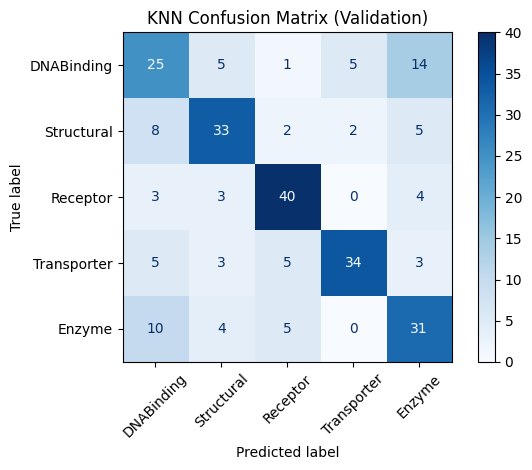

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
# mapping
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
aa_to_idx = {aa: i for i, aa in enumerate(amino_acids)}

# tokenizer
def sequence_to_freq_vector(seq):
    vec = np.zeros(len(aa_to_idx), dtype=np.float32)
    for aa in seq:
        if aa in aa_to_idx:
            vec[aa_to_idx[aa]] += 1
    return vec / len(seq) if len(seq) > 0 else vec

# feature
X_train_feat = np.array([sequence_to_freq_vector(seq) for seq in X_train])
X_valid_feat = np.array([sequence_to_freq_vector(seq) for seq in X_valid])

# build KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_feat, y_train)

# prediction
y_pred = knn.predict(X_valid_feat)

class_names = ["DNABinding", "Structural", "Receptor", "Transporter", "Enzyme"]

# output
print("\n📋 Classification Report:")
print(classification_report(y_valid, y_pred, target_names=class_names))

# confusion
cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("KNN Confusion Matrix (Validation)")
plt.tight_layout()
plt.show()

In [ ]:
# saving path
save_dir = os.path.join(rootPath, "knn_results")
os.makedirs(save_dir, exist_ok=True)

# 1. acc
from sklearn.metrics import accuracy_score
val_acc = accuracy_score(y_valid, y_pred)

acc_df = pd.DataFrame({
    "Epoch": [1],
    "Train_Accuracy": [None],
    "Valid_Accuracy": [val_acc]
})
acc_df.to_csv(os.path.join(save_dir, "knn_accuracy_log.csv"), index=False)

# 2. confusion
cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("KNN Confusion Matrix (Validation)")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "knn_confusion_matrix.png"))
plt.close()

print(f"saved: Acc -> CSV，confusion metric -> PNG ({save_dir})")

✅ 保存完成: 准确率 -> CSV，混淆矩阵 -> PNG (/content/gdrive/MyDrive/Colab_Notebooks_Xinyu/Bio/knn_results)


In [ ]:
plot_tsne_projection(X_train_feat, y_train, class_names, save_dir=os.path.join(rootPath, "knn_results"), prefix="knn")


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


✅ t-SNE 图已保存: /content/gdrive/MyDrive/Colab_Notebooks_Xinyu/Bio/knn_results/knn_tsne_plot.png


# SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import os
import matplotlib.pyplot as plt
import pandas as pd

svm_dir = os.path.join(rootPath, "svm_results")
os.makedirs(svm_dir, exist_ok=True)

#  SVM
svm = SVC(kernel='rbf', C=1.0, gamma='scale')
svm.fit(X_train_feat, y_train)

# Prediction
y_pred = svm.predict(X_valid_feat)

print("📋 SVM Classification Report:")
print(classification_report(y_valid, y_pred, target_names=class_names))

from sklearn.metrics import accuracy_score
val_acc = accuracy_score(y_valid, y_pred)

acc_df = pd.DataFrame({
    "Epoch": [1],
    "Train_Accuracy": [None],
    "Valid_Accuracy": [val_acc]
})
acc_df.to_csv(os.path.join(svm_dir, "svm_accuracy_log.csv"), index=False)
# confusion
cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("SVM Confusion Matrix (Validation)")
plt.tight_layout()
plt.savefig(os.path.join(svm_dir, "svm_confusion_matrix.png"))
plt.close()

# classification report
with open(os.path.join(svm_dir, "svm_classification_report.txt"), "w") as f:
    f.write(classification_report(y_valid, y_pred, target_names=class_names))

print(f"SVM results has saved to: {svm_dir}")


📋 SVM Classification Report:
              precision    recall  f1-score   support

  DNABinding       0.59      0.68      0.63        50
  Structural       0.68      0.64      0.66        50
    Receptor       0.77      0.72      0.74        50
 Transporter       0.80      0.74      0.77        50
      Enzyme       0.65      0.68      0.67        50

    accuracy                           0.69       250
   macro avg       0.70      0.69      0.69       250
weighted avg       0.70      0.69      0.69       250

✅ SVM 结果保存至: /content/gdrive/MyDrive/Colab_Notebooks_Xinyu/Bio/svm_results


In [ ]:
plot_tsne_projection(X_train_feat, y_train, class_names, save_dir=os.path.join(rootPath, "svm_results"), prefix="svm")


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


✅ t-SNE 图已保存: /content/gdrive/MyDrive/Colab_Notebooks_Xinyu/Bio/svm_results/svm_tsne_plot.png
